# Model I: Support Vector Machine (SVM) + Zernike Moments (ZMs)

In this notebook we use Model I by Ghaderi et al. (2025) (https://iopscience.iop.org/article/10.3847/1538-4365/ada8ab) to classify images into galaxies and non-galaxies. Their original code is available on GitHub at: https://github.com/hmddev1/machine_learning_for_morphological_galaxy_classification

At the end of the notebook we explore the accuracy as a function of maximum Zernike Polynomial order number.

This model uses **just** the Zernike Moments (ZMs) as the data to classify the galaxies. These are essentially features extracted from the images mathematically, so a CNN is not needed here, at least not in the traditional sense. The Zernike order used in this model is 45.

In [ ]:
import os
path = '/content/drive/Shared drives/DLP Project/Project/Models/Galaxy-Nongalaxy Models'
os.chdir(path)

In [ ]:
%run imports.py
%matplotlib inline

In [ ]:
import plotting

## Loading the data and the labels

In [ ]:
# This cell takes a while
galaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/galaxy_zms.csv')
nongalaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/nongalaxy_zms.csv')

galaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)
nongalaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)

zmg = np.array(galaxy_zm)
zmng = np.array(nongalaxy_zm)

all_zm_data = np.concatenate([zmg,zmng])
len(zmg), len(zmng), len(all_zm_data)

(780, 555, 1335)

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

1335

## Splitting into train and test sets

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

## Training

The **SVM** model uses radial base kernel (rbf), C = 1.5, and gamma = 'scale' to fit the model on the training set:

In [ ]:
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

## Performance

Now, we apply the model to the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

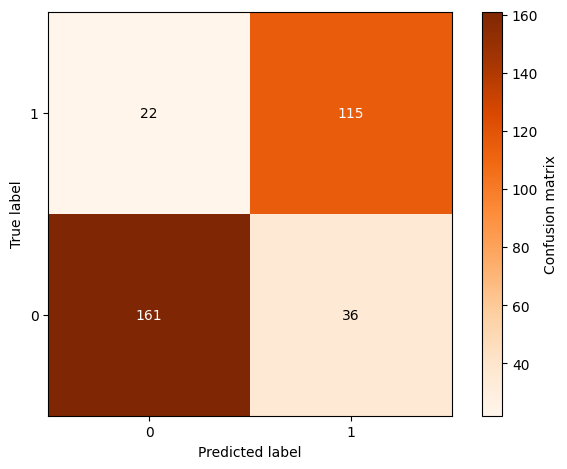

In [ ]:
# Confusion matrix
y_pred = model.predict(X_test)
plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

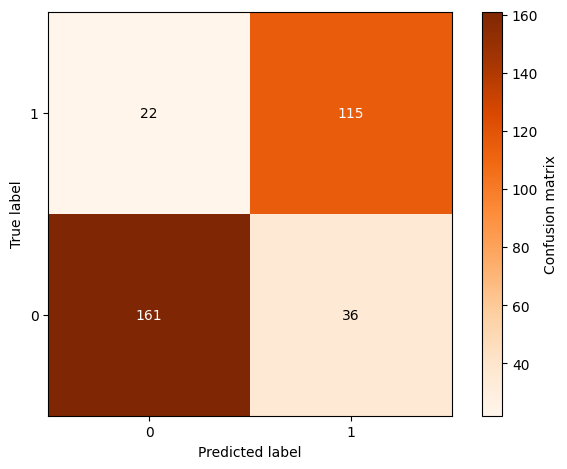

In [ ]:
# Confusion matrix
y_pred = model.predict(X_test)
plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

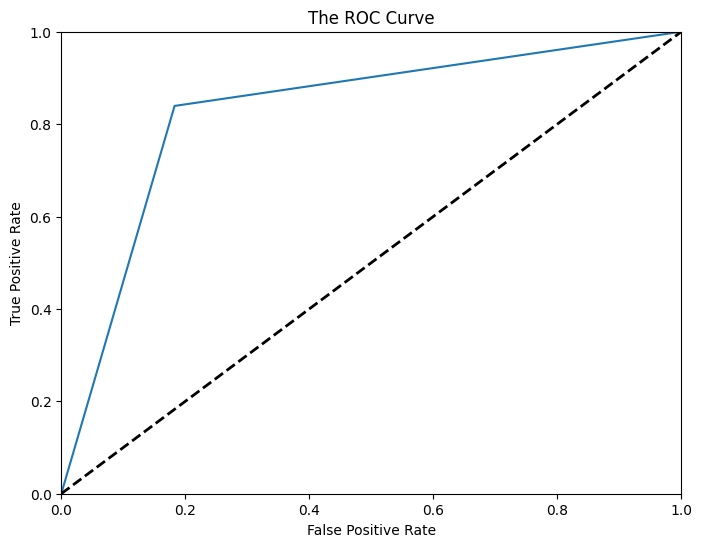

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
recall = recall_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.8263473053892215
Precision: 0.8313014617816804
F1_score: 0.8273691651784152
Accuracy: 0.8263473053892215
TSS: 0.6566749416428915
AUC: 0.8283374708214457


## Accuracy as a function of maximum Zernike Polynomial order number

### Compute the ZMs:

##### We will use the ZEMO python package [https://pypi.org/project/ZEMO/] [https://github.com/hmddev1/ZEMO] to compute Zernike moments (ZMs) for images. This package was described in the research paper [[IAJJ](https://ijaa.du.ac.ir/article_374_ad45803d737b0a7d4fc554a244229df6.pdf)].

*Note: The galaxy and non-galaxy images are in RGB format. Here, we used the R channel of images. The size of original Galaxy Zoo 2 images is (424, 424) pixels, while we resized them to (200, 200) pixels. To compute ZMs we set the maximum order number $P_{max} = 45$.*

In [ ]:
!pip install ZEMO

In [ ]:
import cv2
from ZEMO import zemo
from tqdm import tqdm  # Progress tracking

In [ ]:
def calculate_zernike_moments(data_dir, image_size, zernike_order):

        ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)

        image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        zernike_moments = []

        #for img_path in image_files:
        for img_path in tqdm(image_files, desc="Processing images", unit="image"):

            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (image_size,image_size))
            im = resized_image[:, :, 0]
            Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
            zernike_moments.append(Z)

        df = pd.DataFrame(zernike_moments)

        return df

In [ ]:
data_path = r'/content/drive/Shared drives/DLP Project/Project/Data/'
nongalaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/nongalaxy')
galaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/galaxy')

# Default image size and zernike order.
image_size = 200
zernike_order = 10

In [ ]:
# WARNING: THIS CELL TAKES ABOUT 30 MINUTES TO RUN!

# Calculating Zernike Moments for 5 different maximum
# ZP orders for the galaxy images
#for p in range(10, 50, 10):
#  zernike_order = p
#  galaxy_zm_df = calculate_zernike_moments(galaxy_path, image_size, zernike_order)
#  galaxy_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/galaxy_zms.csv')

In [ ]:
# WARNING: THIS CELL TAKES ABOUT 30 MINUTES TO RUN!

# Calculating Zernike Moments for 5 different maximum
# ZP orders for the nongalaxy images
#for p in range(10, 50, 10):
#  zernike_order = p
#  nongalaxy_zm_df = calculate_zernike_moments(galaxy_path, image_size, zernike_order)
#  nongalaxy_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/nongalaxy_zms.csv')

In [ ]:
def model_order(p, data_path, compute_zms=False, seed=np.random.seed(42), verbose=0):
  """
  This function trains the SVM model on the data with maximum
  Zernike Polynomial order p and returns the trained model and the test data.

  Parameters
  ----------
  p : int
      The maximum ZP order.
  data_path : str
      The path to the data.
  compute_zms : bool
      If True, calculate the Zernike Moments for the images and create
      corresponding CSV files. If False, load the Zernike Moments from the
      CSV files.
  seed : int
      Seed for reproducibility.
  verbose : int
      Verbosity level.

  Returns
  -------
  model : SVC
      The trained SVM model.
  X_test : numpy.ndarray
      The test data.
  y_test : numpy.ndarray
      The test labels.
  """
  if compute_zms:
    # Calculating ZMs for the images
    galaxy_path = os.path.join(data_path, r'galaxy')
    nongalaxy_path = os.path.join(data_path, r'nongalaxy')

    # Check if folder 'P=str(p)' exists and if not, create it
    folder_path = '/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)
    if not os.path.exists(folder_path):
      os.makedirs(folder_path)

    print('Calculating ZMs for galaxy images...') if verbose==1 else None
    galaxy_zm_df = calculate_zernike_moments(galaxy_path, image_size, zernike_order=p)
    galaxy_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/galaxy_zms.csv')

    print('\n') if verbose else None

    print('Calculating ZMs for nongalaxy images...') if verbose==1 else None
    nongalaxy_zm_df = calculate_zernike_moments(nongalaxy_path, image_size, zernike_order=p)
    nongalaxy_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/nongalaxy_zms.csv')

  print('\nLoading data, splitting into train and test sets and training on the train set...') if verbose==1 else None

  # Loading the ZMs
  galaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/galaxy_zms.csv')
  nongalaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/accuracy_vs_max_zp_order/P='+str(p)+'/nongalaxy_zms.csv')

  galaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)
  nongalaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)

  # Data
  zmg = np.array(galaxy_zm)
  zmng = np.array(nongalaxy_zm)
  all_zm_data = np.concatenate([zmg,zmng])

  # Labels
  galaxies_labels = np.zeros(len(zmg))
  nongalaxy_labels = np.ones(len(zmng))
  all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])

  # Split into train and test sets
  X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

  # Accounting for class imbalance
  class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

  # Calling and training the model
  model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale', class_weight=class_weights)
  gz2_training_model = model.fit(X_train, y_train)

  print('\nDone!') if verbose==1 else None

  return model, X_test, y_test

In [ ]:
# Path to images
data_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/'

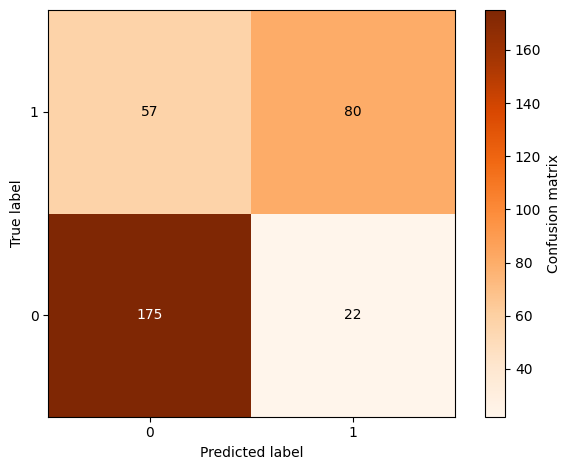

In [ ]:
# Call model for p=1
p = 1
model, X_test, y_test = model_order(p, data_path, compute_zms=False, seed=np.random.seed(42), verbose=0)

# Confusion matrix (p=1)
y_pred = model.predict(X_test)
plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

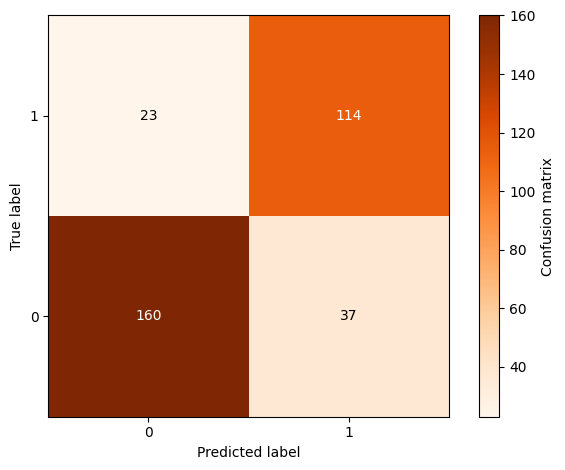

In [ ]:
# Call model for p=10
p = 10
model, X_test, y_test = model_order(p, data_path, compute_zms=False, seed=np.random.seed(42), verbose=0)

# Confusion matrix
y_pred = model.predict(X_test)
plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

We see that there is an improvement in accuracy with higher order as is expected. Now let's train the SVM model for maximum Zernike orders 1 to 45 and see how the accuracy behaves.

In [ ]:
# Path to images
data_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/'

# Training models on datasets with different Zernike Polynomial maximum orders
accuracies = []
for p in range(1, 46, 1):
  print(f'Training model for p = {p} ...')
  model, X_test, y_test = model_order(p, data_path, compute_zms=False, seed=np.random.seed(42), verbose=0)

  print('\n')

  # Accuracy
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

  # Confusion matrix
  #y_pred = model.predict(X_test)
  #plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

Training model for p = 1 ...


Training model for p = 2 ...


Training model for p = 3 ...


Training model for p = 4 ...


Training model for p = 5 ...


Training model for p = 6 ...


Training model for p = 7 ...


Training model for p = 8 ...


Training model for p = 9 ...


Training model for p = 10 ...


Training model for p = 11 ...


Training model for p = 12 ...


Training model for p = 13 ...


Training model for p = 14 ...


Training model for p = 15 ...


Training model for p = 16 ...


Training model for p = 17 ...


Training model for p = 18 ...


Training model for p = 19 ...


Training model for p = 20 ...


Training model for p = 21 ...


Training model for p = 22 ...


Training model for p = 23 ...


Training model for p = 24 ...


Training model for p = 25 ...


Training model for p = 26 ...


Training model for p = 27 ...


Training model for p = 28 ...


Training model for p = 29 ...


Training model for p = 30 ...


Training model for p = 31 ...


Training model fo

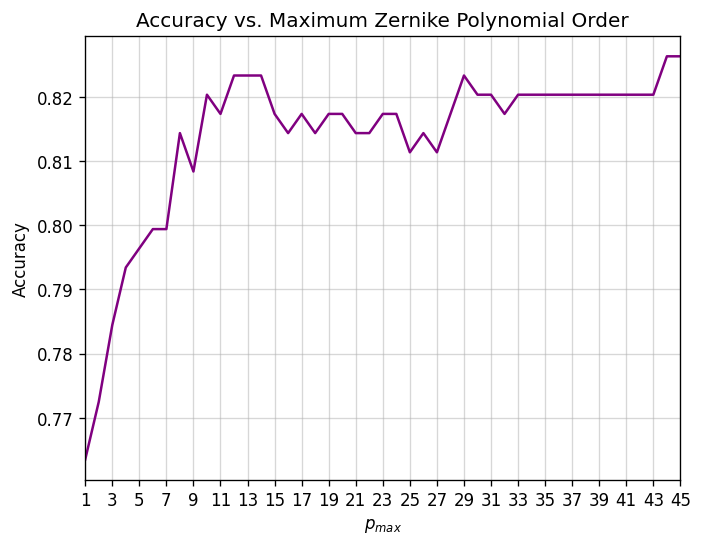

In [ ]:
# Accuracy as a function of Zernike order
plt.figure(dpi=120)
plt.plot(np.arange(1, 46, 1), np.array(accuracies), color='purple')
plt.xlabel('$p_{max}$')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Maximum Zernike Polynomial Order')
plt.xticks(np.arange(1, 46, 2))
plt.xlim(1,45)
plt.grid(True, alpha=0.5)
plt.show()